## FINAL CAPSTONE: MOVIE RECOMMENDER

In this final project i have planned to develope movie Recommendation system.Recommender systems are one of the most valuable applications developed using machine learning in today's technological advancement. Amazon attributes its 35% of revenue to its recommender system. According to a [paper](https://www.martechadvisor.com/articles/customer-experience-2/recommendation-engines-how-amazon-and-netflix-are-winning-the-personalization-battle/) the on-demand video streaming service claims its AI assisted recommendation system makes the company $1 billion per year.Customer experience personalization is developed and optimized using datas.

In 2009 [Netflix awarded a $1 million prize](https://www.wired.com/2012/04/netflix-prize-costs/) to a developer team for an algorithm that increased the accuracy of the company's recommendation engine by 10 percent.This shows how vital it is to implement a better performing model which increases the accuracy of already existing model.This will enable a better customer experience,reduce churn and increase revenue by a jump and the same applies to the solution that i have planned to work on. In my case however i will use a portion of [Amazon movies review data from Kaggle](https://www.kaggle.com/dm4006/amazon-movie-reviews) and i will download the data to my local machine take a portion of it as it is large considering the constraint of machine power;transform it,clean it explore it and finaly apply the further analysis procedures.

Different recommender systems apply different techniques to solve the same problem,But the robustness of the performance of these techniques and the condition that they work best differce from one to another.In this capstone i have applied a technique that integrates the main variables such as movies,viewers, and date with the review scores from viewers and NLP sentiment analysis techniques to extract a meaningfully applicable words from text reviews for feature creation and modeling.

Lets get started by downloading the most commonly used modules for our process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import spacy
import re
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize,Normalizer,StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
%matplotlib inline

The dataset size is very large to be properly processed in my local machine therefore i have processed the dataset to a usable format under the constraint of machine power.Lets move on to the code for reading the file;

In [2]:
with open('./movies.txt', encoding='iso-8859-1') as f:
      lines = [f.readline() for i in range(10**7)] 

Lets see ten lines from our document.

In [3]:
lines[0:10]

['product/productId: B003AI2VGA\n',
 'review/userId: A141HP4LYPWMSR\n',
 'review/profileName: Brian E. Erland "Rainbow Sphinx"\n',
 'review/helpfulness: 7/7\n',
 'review/score: 3.0\n',
 'review/time: 1182729600\n',
 'review/summary: "There Is So Much Darkness Now ~ Come For The Miracle"\n',
 'review/text: Synopsis: On the daily trek from Juarez, Mexico to El Paso, Texas an ever increasing number of female workers are found raped and murdered in the surrounding desert. Investigative reporter Karina Danes (Minnie Driver) arrives from Los Angeles to pursue the story and angers both the local police and the factory owners who employee the undocumented aliens with her pointed questions and relentless quest for the truth.<br /><br />Her story goes nationwide when a young girl named Mariela (Ana Claudia Talancon) survives a vicious attack and walks out of the desert crediting the Blessed Virgin for her rescue. Her story is further enhanced when the "Wounds of Christ" (stigmata) appear in her 

In turning the information in the above in to a usable DataFrame, I applied the following codes; 

In [4]:
#each information is put in a list of lists
tons_of_lists= []
for i, line in zip(range(len(lines)), lines):
    if line == '\n':
        tons_of_lists.append(lines[:i])
        del(lines[:i+1])
        number = 0  

In [5]:
#
list_with_all_dicts = []
for mini_list in tons_of_lists:
    dict_with_synopsis = {}
    for item in mini_list:
        if ':' in item:
            dict_with_synopsis[item.split(':', maxsplit= 1)[0]] = item.split(':', maxsplit= 1)[1]
            list_with_all_dicts.append(dict_with_synopsis)

In [6]:
#The resulting data frame happened to have duplicated rows,thus I removed the duplicates
movies_df = pd.DataFrame(list_with_all_dicts)
movies_df = movies_df.drop_duplicates()

#editing column names
new_cols = []
for column in movies_df.columns:
    new_cols.append(column.split('/')[1])
movies_df.columns = new_cols    

In [7]:
movies_df.head()

,productId,helpfulness,profileName,score,summary,text,time,userId
0,B003AI2VGA\n,7/7\n,"Brian E. Erland ""Rainbow Sphinx""\n",3.0\n,"""There Is So Much Darkness Now ~ Come For The...","Synopsis: On the daily trek from Juarez, Mexi...",1182729600\n,A141HP4LYPWMSR\n
8,B003AI2VGA\n,8/10\n,"Chrissy K. McVay ""Writer""\n",5.0\n,This movie needed to be made.\n,The scenes in this film can be very disquieti...,1164844800\n,A1I7QGUDP043DG\n
24,B003AI2VGA\n,0/0\n,"abra ""a devoted reader""\n",2.0\n,Pretty pointless fictionalization\n,The murders in Juarez are real. This movie is...,1229040000\n,A3QYDL5CDNYN66\n
48,B00006HAXW\n,24/24\n,"""bruce_from_la""\n",5.0\n,If You Like DooWop You Gotta Have This DVD\n,Wow! When I saw this show on PBS--that was it...,1061164800\n,A2P7UB02HAVEPB\n
80,B00006HAXW\n,7/7\n,"""fellafromnyc""\n",4.0\n,"They sang in the subway, in halls..\n",The performance of Little Anthony and the Imp...,1049846400\n,A1OUBOGB5970AO\n


In [8]:
# I dropped two columns('helpfulness','summary') from the data
movies_df = movies_df[['userId', 'productId', 'score', 'text', 'time']]

In [9]:

for cols in movies_df.columns:
    movies_df[cols] = movies_df[cols].apply(lambda x: x.strip())
    movies_df[cols] = movies_df[cols].apply(lambda x: re.sub(r'\n', '', x))

In [10]:
movies_df['score'] = movies_df['score'].astype('float64')

In [11]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1491 entries, 0 to 8865200
Data columns (total 5 columns):
userId       1491 non-null object
productId    1491 non-null object
score        1491 non-null float64
text         1491 non-null object
time         1491 non-null object
dtypes: float64(1), object(4)
memory usage: 69.9+ KB


From the above info table we can understand that with the duplicates our movies data frame would have 8865200 entries or rows.

In [12]:
movies_df.head()

,userId,productId,score,text,time
0,A141HP4LYPWMSR,B003AI2VGA,3.0,"Synopsis: On the daily trek from Juarez, Mexic...",1182729600
8,A1I7QGUDP043DG,B003AI2VGA,5.0,The scenes in this film can be very disquietin...,1164844800
24,A3QYDL5CDNYN66,B003AI2VGA,2.0,The murders in Juarez are real. This movie is ...,1229040000
48,A2P7UB02HAVEPB,B00006HAXW,5.0,"Wow! When I saw this show on PBS--that was it,...",1061164800
80,A1OUBOGB5970AO,B00006HAXW,4.0,The performance of Little Anthony and the Impe...,1049846400


In [13]:
movies_df.tail()

,userId,productId,score,text,time
8817712,A3043P11OIPUHE,B001G5RST4,2.0,The Movie Madagascar is terrible for children....,1233014400
8829576,AN9J46667D80O,B0087ZG7KM,4.0,"And so the masses cried out,""Where is the twen...",1305417600
8841448,A7VEQLY06X32Q,B00287Z19I,5.0,"""New Tricks"" is a very well done police drama ...",1335312000
8853320,A35ZK3M8L9JUPX,B00004UB7B,5.0,Marcus is a successful advertising executive w...,1262217600
8865200,A3PCTD8QM1BIXI,B00009X8LF,3.0,Head Of State is a pretty funny movie from the...,1221350400


In [14]:
movies_df.reset_index(inplace = True, drop = True)

### Recommender Systems
**Generally, recommender systems can be one of the below six or more classes:**
    
- **Content-based:** These system learns to recommend items that are similar to the
ones that the user liked in the past.
- **Collaborative Filtering:** The simplest and original implementation of this
approach recommends to the active user the items that other users with similar tastes
liked in the past. “Wisdom of the crowd” to recommend item!
- **Demographic:** This type of system recommends items based on the demographic
profile of the user.
- **Knowledge-based:** Knowledge-based systems recommend items based on
specific domain knowledge about how certain item features meet users needs and
preferences and, ultimately, how the item is useful for the user.
- **Community-based:** This type of system recommends items based on the
preferences of the users friends. This technique follows the epigram “Tell me who your
friends are, and I will tell you who you are”.
- **Hybrid:** This type of system are based on the combination of the above mentioned
techniques.

In this Project i will be applying a Hybrid of Content-based and Collaborative Filtering classes.This is because i will depend on two important columns values in identifying the relationship between the test of movies of one user to another based on how one users evaluated the movies based on the rating score and sentiment analysis pattern of the reviews.having said that in identifying those relationships i desided to depend on one of the clustering algorisms as oposed to the common approaches taken by other techniques, for the following reasons;
1. Logically it is good practice to have the algorism or technque to select only those well average reviewed Movies in general.And then see the relationship to recommend those movies between the tests of the viewers.However because of the nature of my dataset it is difficulty to find the real avarage of movie scores.
2. Most of the movies has only one reviewer. That is if a movie is really bad but one review is 5 or high then it may meslead the recommendation.

Therefore because of the above and other unseen situations i decieded the algorism to deside for itself between the homegeniety of the test of viewers.But First and for most lets deep dive in to the world of exploration and Feature Engineering and Extraction to have a better understanding about our dataset and the richness of the features for the best result of successfully finding the vital relationships.

### Explarotary Data Analysis(EDA)

How many movies does this new subset of the main dataset has? How many reviewers? And at a glance lets see which movies have the highest rating score out of five.

It is very important to know how many movies does our dataset has.

In [15]:
#Total Number of Movies
movies_df['productId'].nunique()

1369

And it is Equally important to know the number of movie reviewers.

In [16]:
# Total Number of viewers
movies_df['userId'].nunique()

1439

Lets see the proportion of the number of reviewers per each movie across the dataset.But first lets find the unique number of reviews per movie.

In [17]:
set(movies_df['userId'].value_counts().values)

{1, 2, 3, 4}

From the above values inside the curl bracket we can understand that all the movies has on of the values number of reviewers.Lets move on and see the proportion of each value across the dataset.

{1: 0.937625754527163, 2: 0.021462105969148222, 3: 0.004694835680751174, 4: 0.0013413816230717639}


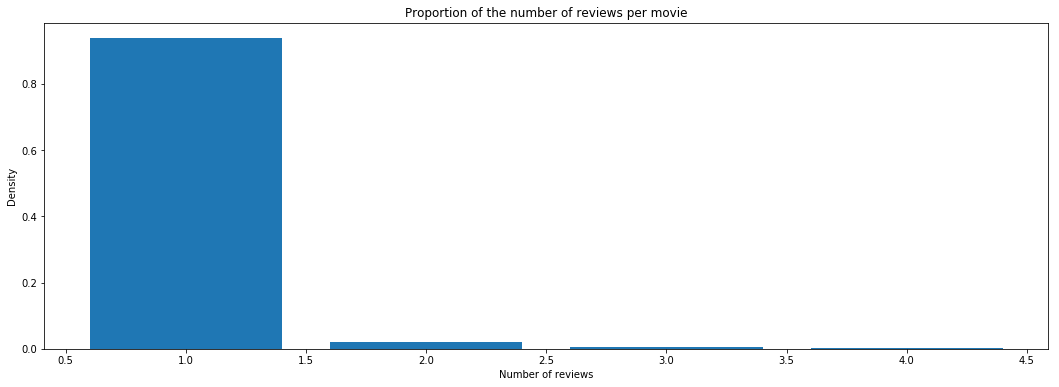

In [18]:
dict_user_count = {}
for i in set(movies_df['userId'].value_counts().values): 
    dict_user_count[i] =(movies_df['userId'].value_counts().values == i).sum()/len(movies_df['userId'])
print(dict_user_count)
plt.figure(figsize = (18, 6))
plt.bar(dict_user_count.keys(), dict_user_count.values())
plt.title('Proportion of the number of reviews per movie');
plt.xlabel('Number of reviews')
plt.ylabel('Density');

From the dictionary and the plot on the above we can learn that 94 percent of the movies were reviewed only once, only 6 percent of the movies got reviews more than one time.We have a very biased dataset.But this analysis have a great value with or with out biasness;the accuracy however is expected to suffer. The most important aspect of it is, its scalability and there is always room for improvement.

In [19]:
scores = pd.DataFrame(movies_df.groupby('productId')['score'].mean().sort_values(ascending = False))
scores.head(10)

,score
productId,
B000C20VSW,5.0
B0001DHSC4,5.0
B0001Y4MAO,5.0
B0001WTWCO,5.0
B0001NBMH6,5.0
B0001MDPIG,5.0
B0001IXT36,5.0
B0001I562I,5.0
B0001HK21Y,5.0


So as we can see on the above these 10 products(Movies) has the highest score i.e score of five among many others.But to be exact lets find out how many movies have an average score of five.

In [20]:
(movies_df.groupby('productId')['score'].mean().values == 5.0).sum()

738

The above figure is telling us that over 50% of our movies has review of exactly 5. Not 4, 4.5, 3.5 or any thing but exactly 5.This shows that there are pretty high number of movies with a single review.Let me clarify it using the table below;

In [21]:
scores['n_ratings'] = pd.DataFrame(movies_df.groupby('productId')['score'].count())
scores.head(10)

,score,n_ratings
productId,,
B000C20VSW,5.0,1
B0001DHSC4,5.0,1
B0001Y4MAO,5.0,1
B0001WTWCO,5.0,1
B0001NBMH6,5.0,1
B0001MDPIG,5.0,1
B0001IXT36,5.0,1
B0001I562I,5.0,1
B0001HK21Y,5.0,1


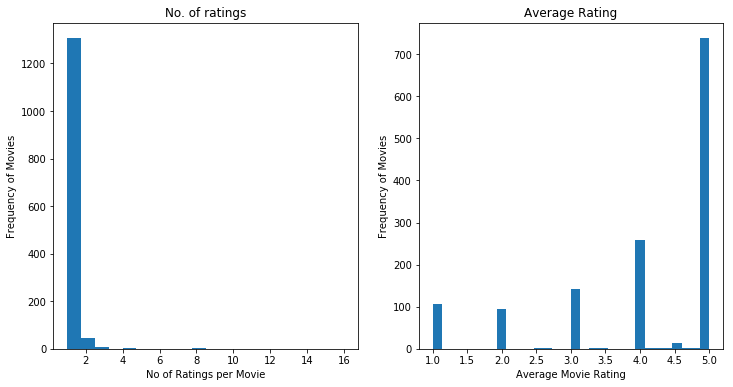

In [22]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# For Average ratings 
ax1.set_title('No. of ratings')
ax1.hist(scores['n_ratings'], bins =20);
ax1.set_xlabel('No of Ratings per Movie')
ax1.set_ylabel('Frequency of Movies')


# For rating Frequency
ax2.set_title('Average Rating')
ax2.hist(scores['score'], bins =30);
ax2.set_xlabel('Average Movie Rating')
ax2.set_ylabel('Frequency of Movies');

From the above 'No. of ratings histogram'(the left figure), we can learn that over 85% of the movies have only 1 reviewer. But to find out about real movie score we technically need the opinion of quite some people and then we can average the scores to get the representative score.From the 'Average Rating' histogram on the right we can see that majority of the ratings are 5,but majority of those scores are the insight of a single viewer.but we have desent number of other scores with a single reviewer too.Those issues would be very conserning if we are going to highly depend on the review scores to recommend a movie for istance we may take a stance that a highly reviewed movie should be recommended to customers based on their tastes, this idea generally works for other goods and services for movies however regardless how other people scores a movie,a high percent of people may still want to see that movie,like the movie 'Room' the worst movie ever made, still people want to see it for been bad, even other different movies people may want to see them for different reasons regardless of the quality of acting, recording,directing and so forth.Our hybrid recommender system therefore will depend on several characteristics on top of review scores to find the relationship between viewers,quality of movie, time and the sentiment a viewer has with certain movies.I have worked to connect the dots in using the concept of NLP and other features to prepare for clustering algorism to come up with the most robust recommender.But first lets prepare the field by desgning the features.

### FEATURE ENGINEERING

To make a use of sentiment analysis in our data,the first step is to turn a Text in to a Data Frame.To do that there are several techniques that are commonly practiced in NLP data preparation.In this case i have applied the Term Frequency - Inverse Document Frequency(TF-IDF) sparse matrix technique to create the data frame using Vectorization method from Sklearn library.Lets move along and see what it looks like in practicality.

In [23]:
reviews_data = pd.DataFrame(movies_df['text'])
reviews_data.head()

,text
0,"Synopsis: On the daily trek from Juarez, Mexic..."
1,The scenes in this film can be very disquietin...
2,The murders in Juarez are real. This movie is ...
3,"Wow! When I saw this show on PBS--that was it,..."
4,The performance of Little Anthony and the Impe...


In [24]:
#Lets label the two Id and the time variables for converting the categorical variables in to numerical
labeled_df = pd.DataFrame()
for col in ['userId', 'productId', 'time']:
    labeled_df[col] = pd.Series(pd.factorize(movies_df[col])[0])

In [25]:
labeled_df.shape

(1491, 3)

Mean-shift is non-flat geometry clustering algorism, there evaluating the algorism using silhouette score may not give us that great result as per the theory.K-means is a robust flat geometry clustering algorism.And applying the Silhouette score evaluation metric gives an efficient result.

In [26]:
nlp = spacy.load('en_core_web_sm') # I wanted to lemmatize the tokens for a best result.
#preparing the reviews to be vectorized for Tfidf model
review_array = []
for review in reviews_data['text']:
    review = re.sub(r'--',' ',review)
    review = re.sub(r"[\[/].*?[\]]", "", review)
    review = re.sub(r'<.*?>', "", review)
    review = nlp(review)
    lemmas = []
    for token in review:
        if not token.is_punct:
            lemmas.append(token.lemma_)
    review_array.append(' '.join(lemmas))
    
# Lets see one reviews
print(review_array[0])

synopsis on the daily trek from Juarez Mexico to El Paso Texas an ever increase number of female worker be find rape and murder in the surround desert investigative reporter Karina Danes Minnie Driver arrive from Los Angeles to pursue the story and anger both the local police and the factory owner who employee the undocumented alien with -PRON- pointed question and relentless quest for the truth -PRON- story go nationwide when a young girl name Mariela Ana Claudia Talancon survive a vicious attack and walk out of the desert credit the Blessed Virgin for -PRON- rescue -PRON- story be further enhance when the Wounds of Christ stigmata appear in -PRON- palm -PRON- also claim to have receive a message of hope for the Virgin Mary and soon a fanatical movement form around -PRON- to fight against the evil that hold such a stranglehold on the area Critique possess a lifelong fascination with such esoteric matter as catholic mysticism miracle and the mysterious appearance of the stigmata -PRON-

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=30, # only use words that appear at least 50 times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
data_norm_tfidf=vectorizer.fit_transform(review_array)
print("Number of features: %d" % data_norm_tfidf.get_shape()[1])


Number of features: 526


It is interesting to see that there are 423 features engineered from the 'text' column.It is too many features it could have been even close to 10000 had i not tunned 'the min_df' attribute in the Tfidfvectorizer function to a large number which is 30,nevertheless highly majority of the features are expected to have from extremely small to almost no effect on the variance explained by the over all features. 

In [28]:

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(30)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
text_lsa = lsa.fit_transform(data_norm_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 23.279626943594618


Selecting the number of components is very important in addressing the issue of overfitting or underfitting.And applying the trade off of increasing the variance under the constraint of combatting overfitting,meaning including too many components will result in overfitting.For this problem i have tried hypertunning the values and came out with 30 components.

In [29]:
text_data = pd.DataFrame(text_lsa)
text_data.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.640952,0.110124,-0.127441,0.140505,0.077773,-0.023655,-0.250505,-0.100102,0.026284,-0.096874,...,0.125798,0.158688,-0.013128,0.051132,0.030883,0.021870,0.189471,-0.077233,-0.028081,0.076850
1,0.573298,0.186219,-0.222584,-0.146214,-0.105971,0.000813,-0.353408,-0.071083,-0.116116,-0.126829,...,0.119881,-0.046233,-0.160605,-0.211971,0.194669,-0.024114,-0.084678,-0.188617,0.049897,-0.018741
2,0.428850,0.003313,-0.095338,-0.182229,-0.122655,-0.165653,0.171971,0.324240,-0.247324,-0.373749,...,-0.015580,-0.056439,0.166380,0.075453,0.114867,0.112017,-0.046709,-0.140640,0.231556,-0.053312
3,0.365456,-0.193082,0.138284,-0.099872,0.184541,0.108156,-0.236139,-0.096464,-0.188674,-0.187514,...,0.021463,0.162173,0.251417,-0.154769,0.238041,0.311940,-0.196040,-0.171644,-0.250261,0.222053
4,0.240683,0.491357,0.708950,-0.143806,-0.035266,-0.010152,0.056789,0.031770,-0.032185,-0.043708,...,-0.120207,0.016493,0.101474,-0.021347,0.070874,-0.086446,-0.162433,-0.128016,-0.017535,0.167634


In [30]:
combined_data = pd.concat([labeled_df, text_data], axis = 1)
combined_data = pd.concat([combined_data, movies_df['score']], axis = 1)

In [31]:
combined_data.head()

,userId,productId,time,0,1,2,3,4,5,6,...,21,22,23,24,25,26,27,28,29,score
0,0,0,0,0.640952,0.110124,-0.127441,0.140505,0.077773,-0.023655,-0.250505,...,0.158688,-0.013128,0.051132,0.030883,0.021870,0.189471,-0.077233,-0.028081,0.076850,3.0
1,1,0,1,0.573298,0.186219,-0.222584,-0.146214,-0.105971,0.000813,-0.353408,...,-0.046233,-0.160605,-0.211971,0.194669,-0.024114,-0.084678,-0.188617,0.049897,-0.018741,5.0
2,2,0,2,0.428850,0.003313,-0.095338,-0.182229,-0.122655,-0.165653,0.171971,...,-0.056439,0.166380,0.075453,0.114867,0.112017,-0.046709,-0.140640,0.231556,-0.053312,2.0
3,3,1,3,0.365456,-0.193082,0.138284,-0.099872,0.184541,0.108156,-0.236139,...,0.162173,0.251417,-0.154769,0.238041,0.311940,-0.196040,-0.171644,-0.250261,0.222053,5.0
4,4,1,4,0.240683,0.491357,0.708950,-0.143806,-0.035266,-0.010152,0.056789,...,0.016493,0.101474,-0.021347,0.070874,-0.086446,-0.162433,-0.128016,-0.017535,0.167634,4.0


### MODELING

In [32]:
scaler = Normalizer()
data_scaled = scaler.fit_transform(combined_data)

### K-Means

Now it is time to cluster our data using one of the most popular clustering algorisms the K-means clustering algorism.Before moving directly to that how ever lets apply the elbow method to find the number of clusters that produces the most optimum clusters. 

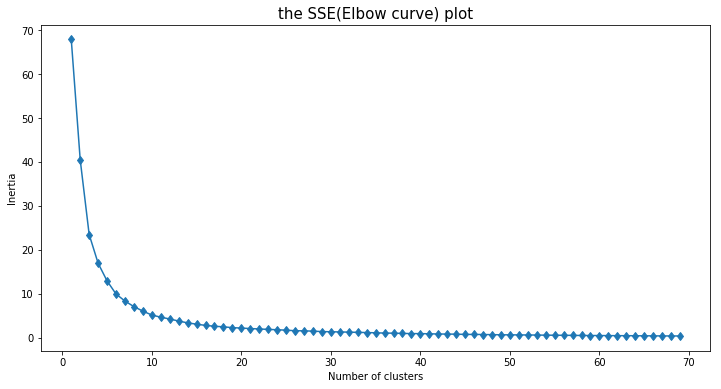

In [33]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,70):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster)
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,70), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='d')
plt.title('the SSE(Elbow curve) plot', fontsize = 15)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

As we can see from the plot the elbow is around 10.Therefore lets group our data into 10 clusters using k-means clustering.

In [34]:
kmeans = KMeans(n_clusters = 8, random_state=45)
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

In [35]:
#K-means clusters with their size
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()

6    657
0    331
5    171
2    111
7    101
1     84
3     30
4      6
Name: cluster, dtype: int64

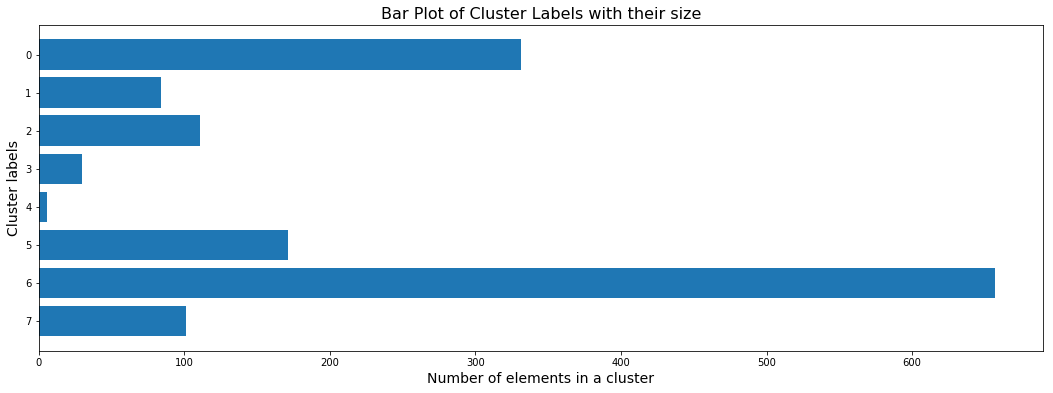

In [36]:

fig, ax = plt.subplots(figsize = (18,6))

ax.barh(frame['cluster'].value_counts().index, frame['cluster'].value_counts().values, align='center')
# ax.set_yticks(frame['cluster'].value_counts().values)
# ax.set_yticklabels(frame['cluster'].value_counts().values)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of elements in a cluster', fontsize = 14)
ax.set_ylabel('Cluster labels', fontsize = 14)
ax.set_title('Bar Plot of Cluster Labels with their size', fontsize = 16)

plt.show()
# plt.xbar(frame['cluster'].value_counts().values, frame['cluster'].value_counts().index)

In [37]:
cluster_labeled_data = pd.concat([movies_df[['userId', 'productId', 'score', 'time']],frame['cluster']], axis = 1)

In [38]:
cluster_labeled_data.head()

,userId,productId,score,time,cluster
0,A141HP4LYPWMSR,B003AI2VGA,3.0,1182729600,4
1,A1I7QGUDP043DG,B003AI2VGA,5.0,1164844800,4
2,A3QYDL5CDNYN66,B003AI2VGA,2.0,1229040000,4
3,A2P7UB02HAVEPB,B00006HAXW,5.0,1061164800,4
4,A1OUBOGB5970AO,B00006HAXW,4.0,1049846400,4


applying k-means does seem to give a good result,Because it did plot a sounding (SSE)elbow shape which is an indication that k-means is doing a good job in finding the clusters.I have expected a large number of clusters for this dataset.The reason is that the sample dataset generated from the large population of movies and viewers from Amazon movies have biasness and this is believed to be a reason for the difference in size for the clusters been generated.Therefore so far, K-means algorism has done tremendous job in creating the recommendation clusters.Lets further strengthen the our findings by applying Silhouette evaluation metric to the k-means clustering to determine its performance.

#### Evaluating K-Means

In [39]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2 = train_test_split(
    data_scaled,
    test_size=0.5,
    random_state=45)

# Then we halve the halves.
X1, X2 = train_test_split(
    X_half1,
    test_size=0.5,
    random_state=45)
X3, X4 = train_test_split(
    X_half2,
    test_size=0.5,
    random_state=45)

In [40]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=29, random_state=25).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.5152072103315463
0.514167639519058
0.4664260337161746
0.5003337014042711


The Silhouette Coefficient values are consistent throughout the samples which is an indication that we have applied the optimum number of clusters for the analysis.The resulting silhouette coefficient values indicate that the clustering algorism used doing good job in clustering the data points.Although K-means performance is good considering the agliness of our dataset, Considering using other techniques is vital part of analysis process.This leads me to try the Affinity propagation clustering algorism to find the grouping for the data points.I had expected there will be many clusters,based on the data analysis process intuition that i developed, and clusters are observed to be uneven insize and also since the size of my data is small this algorism is suited for this situation was my original hypothesis.But first of all lets generate the the cluster assignment along with the text review to access the content of the result of k-means clusters.

#### Accessing cluster contents

Lets see now for example what was said about the movies in cluster number 3 by each reviewer assigned to that cluster.And try to identify any relationships between the nature of the movies that make sense to group them together based on all the features.

In [55]:
cluster_3 = cluster_labeled_data[cluster_labeled_data['cluster'] == 3]

In [56]:
pd.set_option('display.max_colwidth', 1000)
cluster_3 = cluster_3.join(pd.DataFrame(review_array), how = 'left')
cluster_3.head(6)

,userId,productId,score,time,cluster,0
125,A141HP4LYPWMSR,6303998690,3.0,1146787200,3,11 out of 12 reviewer now 12 with mine be in agreement attack of the Giant Leeches be all about the very sexy kittenish Yvette Vickers in the role of the town tramp Liz Walker Yvette undoubtedly get the part base on -PRON- recent popularity as the July 59 playmate of the Month and all the male out there who be in -PRON- adolescence back in the late fifty certainly appreciate -PRON- inclusion in the film -PRON- certainly make -PRON- watchable for -PRON- make no mistake -PRON- be watch this movie for one reason and one reason only thank for the memory Miss Vickers!Note Can -PRON- believe -PRON- one reviewer actually prefer the leech over Yvette now that be scary
242,ABO2ZI2Y5DQ9T,B00005JYAY,5.0,1014422400,3,whatever cynical people say -PRON- be the good movie about the complicated relationship between man and woman which fascinate -PRON- forever Though Meg Ryan prove that -PRON- be a gifted actress who could play tough role in when a man love a woman or courage under fire -PRON- be always Sally to -PRON- Sally whose hilarious fake orgasm be eternally fix in mind of the audience of the whole world have not -PRON- see that -PRON- be a shame if -PRON- do not because -PRON- be so hilarious and make all the man think about -PRON- love and Billy Crystal though the script be write by Nora Ephron -PRON- can find -PRON- trademark joke all over the film see how -PRON- sing a song from musical Oklahoma in front of a karaoke machine see how Harry teach Sally pronouce peeeeeeeacan with -PRON- dead serious face simply irresistible moment -PRON- assure -PRON- but the most unforgettable thing about the film be -PRON- funny clever and most of all natural script by Nora Ephron surpris...
321,AYWSFRCIMOAYE,B00004ST9P,5.0,1154131200,3,"the picture be attractive and gorgeous the dancing be exciting -PRON- make -PRON- dance while watch this dvd the sound be good all of Whitney 's song -PRON- love be here from the lovely and romantic save all -PRON- love for -PRON- to the upbeat and engage how will -PRON- know"" -PRON- love -PRON- so much that -PRON- buy a copy from the local music store right after rent -PRON- the good thing about this disc be -PRON- can turn on the LYRICS this enable -PRON- to sing ALONG.I have be singe with -PRON- since then -PRON- wish all the music dvd allow -PRON- to toggle on the lyric -PRON- be definitely worth buying"
401,AYWSFRCIMOAYE,B003EYVXT6,2.0,1290211200,3,the special effect make Dren the hybrid creature look lively and scary only the first 40 minute be suspenseful after that the movie become insipid and predictable what a waste -PRON- have the potential to become a good science fiction
467,A1R6DF0KOJ0TG6,B00005TNFY,5.0,1043712000,3,this be an awesome concert because the Bee Gees be so relaxed and spontaneous -PRON- be even fun listen to the request call in some of the woman say the same thing -PRON- would have say if -PRON- have be able to view -PRON- live love those guy also -PRON- perform song that be not in some of -PRON- other record concert -PRON- highly recommend this dvd
510,A141HP4LYPWMSR,B000MTEGSG,5.0,1219017600,3,Sydney Penny the enchanting little girl who win the heart of million in the classic 83 television series the Thorn Birds star in the 88 feature film Bernadette the true story of Bernadette Soubirous 1844 1879 the seer who be grace by 18 visitation of a beautiful Lady in White though the film be not available in the U.S.A. until the dvd be recently release -PRON- have be enjoy by million of pilgrim to the catholic shrine in Lourdes France where -PRON- have play daily for the last twenty year i'm admittedly an avid fan of Sydney and so -PRON- comment may not be as objective as -PRON- would like but -PRON- have to say that in -PRON- opinion absolutely no one could have play the role of the little peasant girl better -PRON- angelic face and gentle voice make for the perfect Bernadette this fact be most evident during 

In [43]:
#number of unique users in the cluster 
print(cluster_3['userId'].value_counts())

ABO2ZI2Y5DQ9T     2
A2R6RA8FRBS608    2
A19ZXK9HHVRV1X    2
A141HP4LYPWMSR    2
AYWSFRCIMOAYE     2
A39CX0EE4BZCZC    2
ATQTE464YAZM1     1
A2D8CUJPOSRPNA    1
A4JP4T1F95D0A     1
AJKWF4W7QD4NS     1
A2GOTY2STOMEAU    1
A3Q1FVRV0CRYTH    1
A96K1ZGW56S2I     1
AER15RIMV8E6D     1
A1TJIJKKN15KR9    1
A25ZVI6RH1KA5L    1
A3BSS2M2DPPV4T    1
A19U5RYULZ0Z72    1
A1R6DF0KOJ0TG6    1
A35ZK3M8L9JUPX    1
A1D2C0WDCSHUWZ    1
A9LAPV8XNKZVZ     1
A2FEJIORC1MBG3    1
A13F2IV3ME23R     1
Name: userId, dtype: int64


6 users have been repeated more than once inside cluster 3.Elements in the index#321 and index#401 are similar based on similarity in userdId we needed our algorism to group them together and it successfully did.It has applied the same principle and to the 5 remaining users which are repeated in the cluster.

### Affinity propagation

Therefore because of the following reasons the choice to go for grouping the data points for my recommender system using Affinity propagation made sense.
* The dataset is biased.
* The two important techniques for using k-means proved that k-means is not the way to go,but it would have been if certain criteria such us biasness in data were reduced.
* Affinity propagation is a robust algorism when many clusters are suspected,in this case many clusters are expected.

In [44]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
# Note that you can provide arguments to the model, but we didn't.
af = AffinityPropagation().fit(data_scaled)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))
pred = af.predict(data_scaled)

Done
Estimated number of clusters: 472


In [45]:
frame_1 = pd.DataFrame(data_scaled)
frame_1['cluster'] = pred
frame_1['cluster'].value_counts().head()

465    179
102    112
463     99
96      84
458     53
Name: cluster, dtype: int64

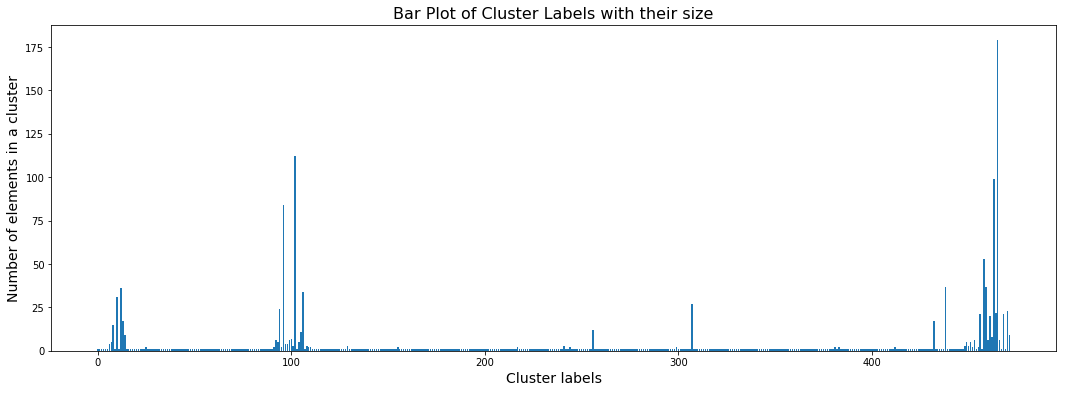

In [46]:
fig, ax = plt.subplots(figsize = (18,6))

ax.bar(frame_1['cluster'].value_counts().index, frame_1['cluster'].value_counts().values, align='center')

ax.set_ylabel('Number of elements in a cluster', fontsize = 14)
ax.set_xlabel('Cluster labels', fontsize = 14)
ax.set_title('Bar Plot of Cluster Labels with their size', fontsize = 16)

plt.show()

oops!Not as expected.Terrible performance for the recommender needs.

Lets use Spectral Clustering which works based on quantifying similiarity and words that often appear in the same context would all be types of "similarity" potentially detectable by these algorithms especially with the text reviews.

In [47]:
from sklearn.cluster import SpectralClustering

# We know we're looking for nine clusters in this case,because the distribution of 
#cluster's size remains about the same after 9 clusters
n_clusters=9

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(data_scaled)

#Predicted clusters.
predict=sc.fit_predict(data_scaled)


In [48]:
frame_2 = pd.DataFrame(data_scaled)
frame_2['cluster'] = predict
frame_2['cluster'].value_counts()

0    769
7    468
5     94
1     89
8     30
4     21
6     16
3      2
2      2
Name: cluster, dtype: int64

I will go for K-means clustering because it is more uniform in the size of the clusters being generated as compared to Spectral clustering.However as the dataset grows this algorism might out perform k-means clustering,therefore it is worth using it when further updating this recommending system in the future.

### SUMMARY AND CONCLUSION

The clusters size increases as viewers,movies and views increase.recommendation clusters tend to change to satisfy the changing viewers viewing behaviour.For instance if userId 'AAECAHBNP1VD2' behaviour of viewing comedy related movies is changed overtime to action movies of certain characteristic,then he is re-assigned by the algorism to another clusters in which those clusters might be completely newly formed clusters from reshaffling viewers or existing clusters of similar taste.It is an ongoing process as events always unfold regarding to transactions of viewing movies.The application of this recommender system at this stage is bestly suited for startup movie channels, As they are assumed to have limited resource in terms of machine power and availability of enough data to aid optimum clustering.This recommender will do great job in recommending custormers movies based on their viewing experience, and satisfaction rate and description of their insights about the movie and the time the movie was viewed.One of the robustness in the over all analysis process is;As the company starts to grow and more data are available from customers then the distribution of the data may become more suited to one of the most popular clustering algorisms which are different to K-means such as Spectral clustering,then we can shift to Those algorisms based on the improvement in the evaluation metrices if our expectation is met.The process and technique that i have applied in this project is highly scalable and easly extendable and customizable to more features in the future studies,such as adding genre, movie description and so forth.It it is expected to boost performance and accuracy by certain level. In the production line this work is expected to extract information from a database process the data which is in a text format in to DataFrames and then apply the clustering technique to group the datapoints in to model identified similiar groups and recommend the same movies from with in the cluster for the members of that cluster.And as i mentioned before it is an itrative process and the outcome slightly differs every time the information in the background database is updated. 

<u>External sources and references</U>

https://en.wikipedia.org/wiki/Silhouette_(clustering)

https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

http://scienceacademy.ca/ds_ml_bc_outline/